# Music Information Retrieval and Emotion Annotation using Lyrics

This notebook attempts to label a dataset of lyrics with emotions, and then perform multilabel classification using the prepared dataset.  
  
  
Please make sure that the required datasets are available. For information on how to get the datasets, read the [README file](https://github.com/huzefaraja/mlnd-capstone-mireal/blob/master/README.md)  

Before continuing, please make sure that the following files are present in the same directory as this notebook:
- text_utils.py
- data_utils.py
- display_utils.py
- lyrics.csv
- NRC-Emotion-Lexicon-Wordlevel-v0.92.txt

Also, this notebook requires Gensim, NLTK, SKLearn, TensorFlow and Keras to be installed.

Let's begin with some imports: 

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore') # to hide warnings such as 'Gensims: detected Windows', and to hide deprecation warnings for TF's random seed

from numpy.random import seed
seed(42)

from tensorflow import set_random_seed
set_random_seed(42)

from IPython.display import display # to display DataFrames
import matplotlib.pyplot as plt
%matplotlib inline

import text_utils # contains methods for processing text
import data_utils # contains methods for retrieving info from topic models, dataframes and word embeddings
import display_utils # contains methods for displaying time and data in some predecided formats

from time import time as now

## Datasets

### Lyrics

The cell below opens the Lyrics dataset, and removes any rows with missing data:

In [2]:
all_data = pd.read_csv("lyrics.csv")
print("Number of songs in the CSV: " + str(len(all_data)))

all_data = all_data.dropna(axis=0, how='any')[['artist', 'song', 'genre', 'year', 'lyrics']].reset_index(drop=True)
print("Number of songs in the CSV after removing missing data: " + str(len(all_data)))


Number of songs in the CSV: 362237
Number of songs in the CSV after removing missing data: 266556


### Data Preprocessing

Below, we remove songs by a few of the artists, and then take the top 500 artists from the remainder of the dataset. Duplicate songs by the same artists are dropped, and songs that have identical lyrics are only kept once.  

In [3]:
data_to_use = all_data[~all_data['artist'].isin(set(['chris-brown','american-idol', 'chumbawamba', 
                                                     'celine-dion', '50-cent', 'chamillionaire', '2pac',
                                                     'frank-zappa','2-chainz','beenie-man', 'akon','ace-hood']))]

n_artists = 500
artists = set(data_to_use['artist'].value_counts()[:n_artists].keys())

data_to_use = data_to_use[data_to_use['artist'].isin(artists)]
print('Number of songs: {0}'.format(len(data_to_use)))

data_to_use = data_to_use.drop_duplicates(subset=['artist', 'song']) # same song from same artist
data_to_use = data_to_use.drop_duplicates(subset=['lyrics']).reset_index(drop=True) # songs with identical lyricss
print('Number of songs after dropping duplicates: {0}'.format(len(data_to_use)))

print("Sample Data: ")
display(data_to_use.sample(5, random_state = 1))

Number of songs: 89634
Number of songs after dropping duplicates: 80539
Sample Data: 


,artist,song,genre,year,lyrics
27641,cocteau-twins,know-who-you-are-at-every-age,Pop,2006,"It seems things are indicative to,\nA distinct..."
34816,bad-religion,the-world-won-t-stop,Rock,2006,You've got to quit your little charade\nAnd jo...
23120,doris-day,t-ain-t-me,Jazz,2016,`Tain't me baby gee I'm blue\n`Tain't me that ...
62398,beautiful-south,love-is,Pop,2006,"Ooh you care, you really, really care\nFrom th..."
67964,george-strait,get-along-with-you,Country,2007,I don't get along\nWith people who aren't kind...


The cell below uses data_utils (which in turn uses text_utils) to process the data. This is a time consuming process. Each song is parsed, and various changes are made to the lyrics to 'clean' the text. I wish I could make a more efficient version.

In [4]:
data = data_utils.process_data(data_to_use)
print('Saving processed data ... ', end='')
%time data.to_csv('processed_data.csv',encoding='utf-8', index=False)

Cleaning lyrics, counting words and detecing language. This may take some time ... 43m 49s 955ms
Removing data with missing features ... 59ms
Removing duplicate data ... 56ms
Sorting data by artist & song title ... 837ms
Saving processed data ... Wall time: 3.87 s


### Data Preprocessing Checkpoint

The preprocessing above is a time consuming process. If it has already been performed, the next cell can be executed without repeating it (thought the earlier imports are still necessary).

In [5]:
print("Loading processed data ... ", end='')
last = now()
data = pd.read_csv('processed_data.csv')
data = data[['artist', 'song', 'genre', 'year', 'lyrics', 'old_word_count', 'cleaned_lyrics', 'new_word_count']]
display_utils.print_time(now() - last)
print("Number of processed songs: %d" % len(data))

Loading processed data ... 1s 898ms
Number of processed songs: 72999


In [6]:
df_orig = data_utils.get_songs_with_min_length(data, 100)
print("Number of songs remaining: %d " % len(df_orig))

Removing songs with word count less than 100 ... 12ms
Number of songs remaining: 12014 


In [10]:
print("A sample of the number of songs by different artists: ")
display(df_orig.artist.value_counts().sample(5, random_state=23))

A sample of the number of songs by different artists: 


david-hasselhoff    17
edguy               14
annihilator          3
elvis-presley       12
b-b-king            18
Name: artist, dtype: int64

### EmoLex (Emotion-Lexicon-Dataset)

Let's take a little bit of a detour now, and access the second piece of data, the lexicon-to-emotions database.  
The code below will parse the TXT and transform to a pandas friendly CSV, that can be then be loaded as necessary.

In [8]:
nrc = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delimiter='\t')

def word_to_emotion(row):
    global df_w2e
    w2e = {}
    w2e = {'word':row['word'][row['word'].index[0]]}
    s = 0
    for index, value in row['emotion'].iteritems():
        is_active = row['active'][index]
        w2e[value] = is_active
        s += is_active
    df_w2e = df_w2e.append(w2e, ignore_index=True)
    
df_w2e = pd.DataFrame(columns=['word', 
                               'anger', 'anticipation', 
                               'disgust', 'fear', 
                               'joy', 'sadness', 
                               'surprise', 'trust', 
                               'sum'])
nrc.groupby(by=['word']).apply(word_to_emotion)
df_w2e['sum'] = df_w2e.anger + df_w2e.anticipation + df_w2e.disgust + df_w2e.fear + df_w2e.joy + df_w2e.sadness + df_w2e.surprise + df_w2e.trust
df_w2e.to_csv('word_to_emotion.csv', encoding='utf-8', index=False)

### Another Data Checkpoint

We can continue from below (after loading the previous checkpoint CSV), if the second dataset has already been parsed.

In [11]:
df_w2e = pd.read_csv('word_to_emotion.csv')
df_w2e = df_w2e[df_w2e['sum'] != 0]
words_w2e = [value for idx, value in df_w2e['word'].iteritems()]

## Vectorization
### Creating the Word2Vec model

The cell below will split the lyrics into lists of words, which will then be used to create a Word2Vec Model.

In [12]:
lyrics_raw_orig = df_orig.cleaned_lyrics.values
lyrics_raw_words_orig = [lines.split() for lines in lyrics_raw_orig]

In [13]:
from gensim.models.word2vec import Word2Vec
w2v_model = Word2Vec(lyrics_raw_words_orig, 
                     workers=1, # to ensure that the model is deterministic
                     size=200, min_count=50, 
                     window=10, sample=1e-3)

Let's see how well the model performs:

In [14]:
data_utils.get_similar_words(w2v_model, 'father', min_relevance=.6)

{'daughter', 'mother', 'sister'}

That seems to be good. The vocabulary of this model will now be combined with emotion carrying words from the Emotion-Lexicon database. This will tell us the number of allowed words:

In [15]:
words_w2v = set(w2v_model.wv.vocab.keys())
words_w2v.update(words_w2e)
words_w2v.remove('don')
print("Number of words allowed: %d" % (len(words_w2v)))

Number of words allowed: 8156


The two cells below will remove words that are not allowed and update the dataset:

In [16]:
lyrics_raw_words = lyrics_raw_words_orig
lyrics_raw = []
for lyrics in lyrics_raw_words:
    lyrics_raw.append(' '.join([word for word in lyrics if word in words_w2v]))

In [17]:
df_temp = df_orig
df_temp['constrained_lyrics'] = lyrics_raw
df_temp['constrained_word_count'] = df_temp['constrained_lyrics'].apply(lambda x: len(x.split()))
df_temp = df_temp[df_temp.constrained_word_count>=90]
df_temp = df_temp.dropna(how='any')
df = df_temp.reset_index(drop=True)
lyrics_raw = df.constrained_lyrics.values

### CountVectorizer

The code below will Vectorize the Documents, and then we create a topic model in the next cell. It will be visualized below.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents = 'unicode',
                                lowercase = True,
                                stop_words = 'english',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
lyrics_vectorized = vectorizer.fit_transform(lyrics_raw)
print("Number of documents: {0}, number of words: {1}".format(lyrics_vectorized.shape[0], lyrics_vectorized.shape[1]))

Number of documents: 10752, number of words: 5474


## Topic Modeling

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20 # number of topics

topic_model = LatentDirichletAllocation(n_components=n_topics, random_state=8, learning_method='online', max_iter=30)
print("Creating Topic Model using LDA with {} iterations ... ".format(topic_model.max_iter), end='')
%time topic_model.fit(lyrics_vectorized)

Creating Topic Model using LDA with 30 iterations ... Wall time: 2min 41s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=30, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=8, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [22]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(topic_model, lyrics_vectorized, vectorizer, sort_topics=False)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       6.001414        1       1 -0.199538 -0.105764
1       3.915099        1       2 -0.046232  0.100700
2       2.263318        1       3  0.024685 -0.060121
3       2.847439        1       4 -0.075508 -0.106165
4       3.484924        1       5 -0.119927 -0.092598
5       9.438642        1       6 -0.095469  0.092124
6       9.118416        1       7 -0.142018 -0.072790
7       0.818394        1       8  0.261973 -0.116978
8       2.580908        1       9 -0.078197 -0.108784
9      13.196072        1      10  0.043339  0.205764
10      2.299887        1      11 -0.087122  0.003714
11      2.573008        1      12  0.089735  0.100811
12      8.687119        1      13 -0.147759  0.039267
13     12.015099        1      14  0.025415  0.227247
14      1.894218        1      15  0.165496  0.124445
15      1.850163        1      16  0.093877 -0.228455
16      6.083211        1      17  0.019461  0.079032
17      1.413069        1      18  0.202657 -0.114508
18      7.694851        1      19 -0.097826  0.053571
19      1.824747        1      20  0.162958 -0.020515, topic_info=     Category          Freq      Term         Total  loglift  logprob
term                                                                 
3188  Default  26299.000000     nigga  26299.000000  30.0000  30.0000
2843  Default  19920.000000      love  19920.000000  29.0000  29.0000
215   Default  11563.000000      baby  11563.000000  28.0000  28.0000
4217  Default  13197.000000      shit  13197.000000  27.0000  27.0000
3067  Default   7537.000000     money   7537.000000  26.0000  26.0000
2027  Default   7662.000000      girl   7662.000000  25.0000  25.0000
1178  Default   6809.000000       day   6809.000000  24.0000  24.0000
2903  Default  11960.000000       man  11960.000000  23.0000  23.0000
1940  Default   8075.000000      fuck   8075.000000  22.0000  22.0000
2066  Default   7033.000000      good   7033.000000  21.0000  21.0000
366   Default   6678.000000     bitch   6678.000000  20.0000  20.0000
1730  Default   7191.000000      feel   7191.000000  19.0000  19.0000
492   Default   4360.000000       boy   4360.000000  18.0000  18.0000
3191  Default   7177.000000     night   7177.000000  17.0000  17.0000
5083  Default   3722.000000      turn   3722.000000  16.0000  16.0000
3016  Default   4847.000000      mind   4847.000000  15.0000  15.0000
3946  Default   3355.000000      rock   3355.000000  14.0000  14.0000
3090  Default   3934.000000    mother   3934.000000  13.0000  13.0000
2220  Default   4246.000000      hard   4246.000000  12.0000  12.0000
4982  Default   2900.000000   tonight   2900.000000  11.0000  11.0000
3783  Default   2987.000000     ready   2987.000000  10.0000  10.0000
1945  Default   5006.000000   fucking   5006.000000   9.0000   9.0000
351   Default   4163.000000       big   4163.000000   8.0000   8.0000
3784  Default   5580.000000      real   5580.000000   7.0000   7.0000
2760  Default   8912.000000      life   8912.000000   6.0000   6.0000
3957  Default   2779.000000      roll   2779.000000   5.0000   5.0000
3908  Default   3184.000000      ride   3184.000000   4.0000   4.0000
1152  Default   2310.000000     dance   2310.000000   3.0000   3.0000
168   Default   5349.000000       ass   5349.000000   2.0000   2.0000
2308  Default   3796.000000      high   3796.000000   1.0000   1.0000
...       ...           ...       ...           ...      ...      ...
3199  Topic20    336.026141     noise    433.277701   3.7495  -4.3639
4020  Topic20     62.162122    saddle     72.609023   3.8484  -6.0513
5009  Topic20   1435.031323      town   2097.235792   3.6243  -2.9121
809   Topic20   1379.772361      city   2091.516549   3.5878  -2.9514
1951  Topic20    790.001525       fun   1214.173078   3.5739  -3.5090
4248  Topic20     74.208493  shouting     89.467909   3.8167  -5.8742
3809  Topic20    990.771883       red  

With the topic model ready, let's initialize some values to defaults and have a look:

In [23]:
df['topics'] = None
df['relevancies'] = None
df['joy'] = int(0)
df['trust'] = int(0)
df['sadness'] = int(0)
df['anger'] = int(0)
df['fear'] = int(0)
df['anticipation'] = int(0)
df['surprise'] = int(0)
df['disgust'] = int(0)

In [25]:
display_utils.display_song_topics(['stan', 'mockingbird', 'marvin-s-room'], df)
display_utils.display_song_emotions(['stan', 'mockingbird', 'marvin-s-room'], df)

# The reason it's NaN is because addition was performed on the topics (to go from indexes to numbers, but None caused NaN)

,song,artist,topics
7234,marvin-s-room,drake,NaN
8192,mockingbird,eminem,NaN
8290,stan,eminem,NaN


,song,artist,joy,trust,sadness,disgust,anger,fear,anticipation,surprise
7234,marvin-s-room,drake,0,0,0,0,0,0,0,0
8192,mockingbird,eminem,0,0,0,0,0,0,0,0
8290,stan,eminem,0,0,0,0,0,0,0,0


The next step is to transform the lyrics and then assign topics to the song:

In [26]:
lyrics_transformed = topic_model.transform(lyrics_vectorized)

In [27]:
dict_t2s = {}

for t in range(n_topics):
    last = now()
    df_song_topics = data_utils.get_songs_for_topic(topic_model, lyrics_transformed, t, 0, df)
    df_song_topics['searched_topic'] = t
    print("Number of songs in topic {0} = {1} ({2}%) ... processing time: ".format(t+1,len(df_song_topics),
                                                                                   round(len(df_song_topics)/len(df)*100)), end='')
    dict_t2s[t+1] = len(df_song_topics)
    display_utils.print_time(now() - last)

Number of songs in topic 1 = 1885 (18%) ... processing time: 6s 709ms
Number of songs in topic 2 = 992 (9%) ... processing time: 3s 307ms
Number of songs in topic 3 = 518 (5%) ... processing time: 2s 158ms
Number of songs in topic 4 = 747 (7%) ... processing time: 3s 235ms
Number of songs in topic 5 = 1106 (10%) ... processing time: 3s 500ms
Number of songs in topic 6 = 3460 (32%) ... processing time: 11s 470ms
Number of songs in topic 7 = 3127 (29%) ... processing time: 9s 294ms
Number of songs in topic 8 = 123 (1%) ... processing time: 1s 48ms
Number of songs in topic 9 = 562 (5%) ... processing time: 2s 254ms
Number of songs in topic 10 = 3986 (37%) ... processing time: 11s 430ms
Number of songs in topic 11 = 492 (5%) ... processing time: 1s 904ms
Number of songs in topic 12 = 540 (5%) ... processing time: 2s 8ms
Number of songs in topic 13 = 3205 (30%) ... processing time: 9s 328ms
Number of songs in topic 14 = 3784 (35%) ... processing time: 10s 950ms
Number of songs in topic 15 =

Let's look at that information as a graph.

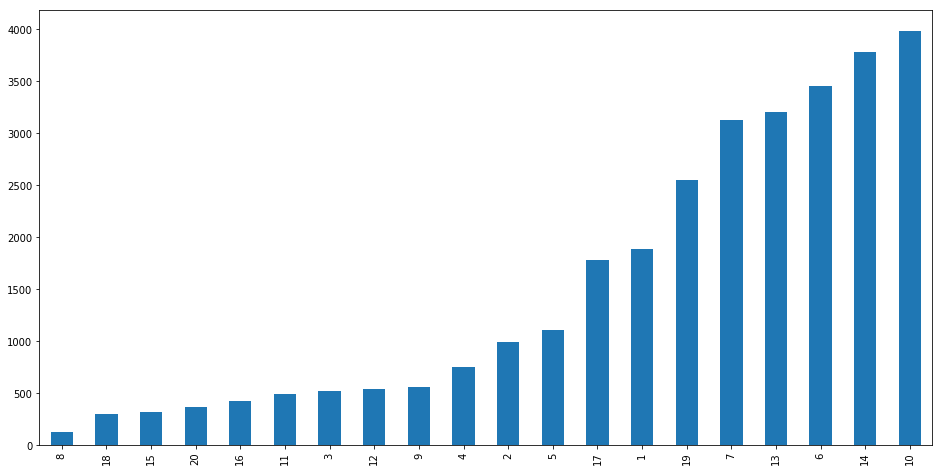

In [28]:
t2s = pd.Series(dict_t2s)
t2s.sort_values(inplace=True)
t2s.plot(kind='bar', figsize=(16,8))

Depending on how emotions are assigned to the topics, we could be looking at some label imbalances. Anyway, let's not get ahead of ourselves, let's look at what topics are assigned to some of the songs:

In [29]:
display_utils.display_song_topics(['stan', 'mockingbird', 'marvin-s-room'], df)

,song,artist,topics
7234,marvin-s-room,drake,"[2, 5, 6, 13]"
8192,mockingbird,eminem,"[3, 13]"
8290,stan,eminem,"[6, 14]"


## Emotion Annotation

Looking at the words for topic 3 and 13, if 3 is assigned 'love' (based on words related to family), and 13 is assigned 'sadness' (based on words like 'broke', 'leave', 'break', 'waiting', 'years', etc,) this might make sense, let's see how the assignment goes.

First we stem the EmoLex dataset, and then we use it to to match the top words in each topic (and words similar to them), to assign emotions to topic, and then review them.

In [30]:
from nltk import PorterStemmer
ps = PorterStemmer()

df_w2e['stem'] = df_w2e['word'].apply(lambda x: ps.stem(x))
df_w2e_stemmed = df_w2e[['stem', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]
df_w2e_stemmed = df_w2e_stemmed.groupby('stem').sum()

words_w2e_stemmed = df_w2e_stemmed.index.tolist()

In [31]:
df_t2e = pd.DataFrame()

words_top = data_utils.get_top_words_for_each_topic(topic_model, vectorizer.get_feature_names(), 50)
word_count = 0
matched_word_count = 0

for t in range(len(words_top)):
    wordset = set(words_top[t])
    t_word_count = 0
    t_matched_word_count =  0
    for word in words_top[t]:
        wordset.update(data_utils.get_similar_words(w2v_model, word, 0.6))
    for word in wordset:
        word_count +=  1
        t_word_count +=  1
        word = ps.stem(word)
        if word in words_w2e_stemmed:
            word_i = words_w2e_stemmed.index(word)
            matched_word_count +=  1
            t_matched_word_count +=  1
        
            df_temp = df_w2e_stemmed.loc[words_w2e_stemmed[word_i:word_i+1]][
                ['anger', 'anticipation', 'fear', 'joy', 'sadness', 'trust']] 
            # dropping 'surprise' and 'disgust' because they are difficult to manually identify
            # also because they are less relevant
            df_temp['topic'] = t
            df_t2e=df_t2e.append(df_temp)
    print("{0} words matched out of {1} words for Topic {2}, ({3}%)".format(t_matched_word_count, t_word_count, t+1,
                                                                            round(t_matched_word_count/t_word_count*100)))

print("{0} words matched out of {1} words in total.\nThat's about {2}% matches.".format(
    matched_word_count, word_count, round(matched_word_count/word_count*100)))

58 words matched out of 113 words for Topic 1, (51%)
57 words matched out of 204 words for Topic 2, (28%)
43 words matched out of 179 words for Topic 3, (24%)
55 words matched out of 171 words for Topic 4, (32%)
58 words matched out of 169 words for Topic 5, (34%)
40 words matched out of 132 words for Topic 6, (30%)
87 words matched out of 216 words for Topic 7, (40%)
100 words matched out of 243 words for Topic 8, (41%)
77 words matched out of 172 words for Topic 9, (45%)
60 words matched out of 223 words for Topic 10, (27%)
53 words matched out of 125 words for Topic 11, (42%)
60 words matched out of 206 words for Topic 12, (29%)
40 words matched out of 115 words for Topic 13, (35%)
46 words matched out of 161 words for Topic 14, (29%)
61 words matched out of 206 words for Topic 15, (30%)
52 words matched out of 174 words for Topic 16, (30%)
44 words matched out of 170 words for Topic 17, (26%)
67 words matched out of 235 words for Topic 18, (29%)
106 words matched out of 175 words f

In [32]:
def get_prominent_emotions(row):
    prominent = max(row)
    match_count = sum(row)
    row = (row/prominent)
    row['prominent_emotions'] = [index for index, value in row.iteritems() if value >= 0.9]
    row['match_count'] = match_count
    return row

In [33]:
df_t2e_grouped = df_t2e.groupby('topic').sum()
df_t2e_assigned = df_t2e_grouped.apply(get_prominent_emotions, axis=1)
df_t2e_assigned.index = df_t2e_assigned.index + 1
display(df_t2e_assigned)

,anger,anticipation,fear,joy,sadness,trust,prominent_emotions,match_count
topic,,,,,,,,
1,0.621622,0.756757,0.513514,1.000000,0.864865,0.864865,[joy],171.0
2,0.709677,0.677419,0.645161,0.645161,0.451613,1.000000,[trust],128.0
3,0.222222,0.518519,0.370370,0.851852,0.481481,1.000000,[trust],93.0
4,0.342857,0.771429,0.571429,0.914286,0.628571,1.000000,"[joy, trust]",148.0
5,0.333333,0.794872,0.487179,1.000000,0.512821,0.846154,[joy],155.0
6,0.178571,0.857143,0.214286,0.714286,0.357143,1.000000,[trust],93.0
7,0.509434,0.641509,0.792453,0.528302,1.000000,0.528302,[sadness],212.0
8,0.728814,0.237288,1.000000,0.203390,0.915254,0.457627,"[fear, sadness]",209.0
9,0.767857,0.357143,0.910714,0.410714,1.000000,0.642857,"[fear, sadness]",229.0


Comparing the data above with the words in the topic model, I would modify the dataset as below:

In [57]:
def modify_t2e(index, value):
    global df_t2e_assigned
    df_t2e_assigned.at[index, 'prominent_emotions'] = value

modify_t2e(1, ['joy','trust','sadness']) # add trust, sadness
modify_t2e(2, ['anticipation','trust']) # add anticipation,  remove trust
modify_t2e(3, ['joy','trust']) # add joy
modify_t2e(4, ['joy','anticipation']) # add anticipation, joy, remove trust
modify_t2e(10, ['anger', 'anticipation']) # remove trust, add anticipation
modify_t2e(12, ['anticipation', 'fear', 'joy']) 
modify_t2e(14, ['anger']) # remove fear
modify_t2e(15, ['anticipation', 'fear']) 
modify_t2e(16, ['joy', 'anticipation']) 
modify_t2e(17, ['joy']) 
modify_t2e(18, ['joy','anger','trust']) 
modify_t2e(19, ['anger', 'fear', 'sadness']) 
modify_t2e(20, ['anticipation', 'fear', 'sadness', 'joy']) 

df_t2e_assigned

,anger,anticipation,fear,joy,sadness,trust,prominent_emotions,match_count
topic,,,,,,,,
1,0.621622,0.756757,0.513514,1.000000,0.864865,0.864865,"[joy, trust, sadness]",171.0
2,0.709677,0.677419,0.645161,0.645161,0.451613,1.000000,"[anticipation, trust]",128.0
3,0.222222,0.518519,0.370370,0.851852,0.481481,1.000000,"[joy, trust]",93.0
4,0.342857,0.771429,0.571429,0.914286,0.628571,1.000000,"[joy, anticipation]",148.0
5,0.333333,0.794872,0.487179,1.000000,0.512821,0.846154,[joy],155.0
6,0.178571,0.857143,0.214286,0.714286,0.357143,1.000000,[trust],93.0
7,0.509434,0.641509,0.792453,0.528302,1.000000,0.528302,[sadness],212.0
8,0.728814,0.237288,1.000000,0.203390,0.915254,0.457627,"[fear, sadness]",209.0
9,0.767857,0.357143,0.910714,0.410714,1.000000,0.642857,"[fear, sadness]",229.0


The graph below shows the number of topics an emotion is present in: 

<Container object of 6 artists>

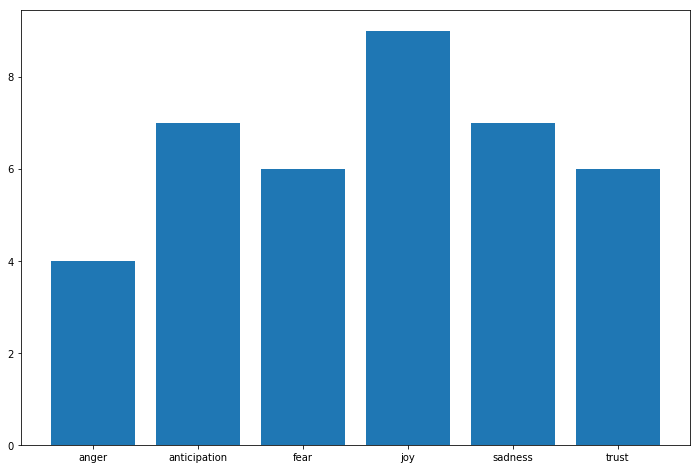

In [58]:
from collections import Counter

flattened_emotions = ([emotion for emotions in df_t2e_assigned.prominent_emotions.values for emotion in emotions])
flattened_emotions_count = Counter(flattened_emotions)

plt.figure(figsize=(12,8))
plt.bar(flattened_emotions_count.keys(), flattened_emotions_count.values())

In [59]:
def assign_prominent_emotions(row):
    global df_t2e_assigned
    topics = row['topics']
    for topic in topics:
        emotions = df_t2e_assigned.at[topic, 'prominent_emotions']
        for emotion in emotions:
            row[emotion] = int(1)
    return row

df_t2e_assigned.index = df_t2e_assigned.index - 1
df = df.apply(assign_prominent_emotions, axis=1).fillna(int(0))
df.to_csv('labeled_data.csv', encoding='utf-8', index=True)

In [62]:
display_utils.display_song_topics(['stan', 'mockingbird', 'marvin-s-room'], df)
display_utils.display_song_emotions(['stan', 'mockingbird', 'marvin-s-room'], df)

,song,artist,topics
7234,marvin-s-room,drake,"[2, 5, 6, 13]"
8192,mockingbird,eminem,"[3, 13]"
8290,stan,eminem,"[6, 14]"


,song,artist,joy,trust,sadness,disgust,anger,fear,anticipation,surprise
7234,marvin-s-room,drake,1,1,1,0,0,0,1,0
8192,mockingbird,eminem,1,1,1,0,0,0,0,0
8290,stan,eminem,0,1,0,0,1,0,0,0


The graph below shows the number of songs each emotion is present in. There is some imbalance, as 'trust' is present in over twice the number of songs as 'fear' 

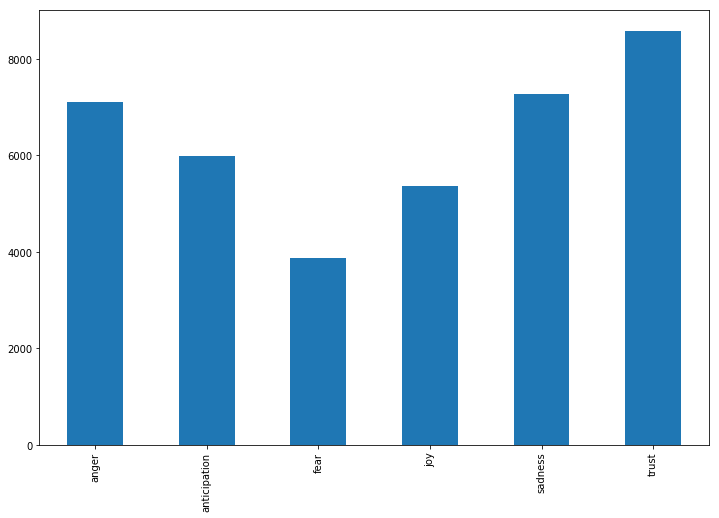

In [63]:
df[ ['anger', 'anticipation', 'fear', 'joy', 'sadness', 'trust']].sum().plot(kind='bar', figsize=(12,8))

## Classification

### Benchmark Classifiers

In [45]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

def fscore(y_true, y_pred):
    return fbeta_score(y_true, y_pred, average='weighted', beta=0.5)

In [64]:
x, y = lyrics_vectorized.toarray(), df[['trust','anger','anticipation','fear','joy','sadness']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=4)
print("Input shape: {}, output shape: {}".format(x_train.shape, y_train.shape))

Input shape: (8601, 5474), output shape: (8601, 6)


In [65]:
classifiers = {
    'OneVsRestClassifier_SVC' : OneVsRestClassifier(SVC(kernel='linear', random_state=4),n_jobs=-1),
    'OneVsRestClassifier_Perceptron' : OneVsRestClassifier(Perceptron(random_state=4),n_jobs=-1),
    'MLPClassifier' : MLPClassifier(random_state=4)
}

In [66]:
for clf_name, clf in classifiers.items():
    print()
    print(clf_name + ":")
    
    last = now()
    clf.fit(x_train, y_train)
    print('Time taken for training = ', end='')
    display_utils.print_time(now()-last)

    last = now()
    y_pred = clf.predict(x_test)
    print('Time taken for prediction = ', end='')
    display_utils.print_time(now()-last)
    
    print('F-Score = ', end='')
    print(fscore(y_test, y_pred))
    
    print()


OneVsRestClassifier_SVC:
Time taken for training = 10m 13s 264ms
Time taken for prediction = 4m 51s 693ms
F-Score = 0.8509206782283636


OneVsRestClassifier_Perceptron:
Time taken for training = 7s 791ms
Time taken for prediction = 440ms
F-Score = 0.8534511738590372


MLPClassifier:
Time taken for training = 2m 41s 481ms
Time taken for prediction = 150ms
F-Score = 0.8730384636452395



### The Final Model

In [70]:
from keras.callbacks import Callback, ModelCheckpoint

class F1BetaCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.df = pd.DataFrame()

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test = self.test_data
        y_pred = model.predict(x_test)
        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0
        logs['f1_score']=fscore(y_test, y_pred)
        self.df = self.df.append({'epoch':epoch, 'f1_score':logs['f1_score']}, ignore_index=True)

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.initializers import TruncatedNormal
from keras.regularizers import l1_l2
from keras.optimizers import SGD, Adam

model = Sequential()
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model.add(Dense(256, activation='relu', input_dim=input_dim))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

filepath="weights.best"
checkpoint = ModelCheckpoint(filepath, monitor='f1_score', verbose=1, save_best_only=True, mode='max')
f1test = F1BetaCallback((x_test, y_test))
last = now()
model_hist = model.fit(x_train, y_train, 
                       epochs=10, 
                       batch_size=256, verbose=1,
                       callbacks=[f1test, checkpoint], 
                       shuffle=True)
print("Total time taken for training: ",  end='')
display_utils.print_time(now() - last)
display(f1test.df.describe())
model.save_weights('weights.last')
pd.DataFrame(model_hist.history)

Epoch 1/10
8601/8601 [==============================] - 4s 422us/step - loss: 0.4865

Epoch 00001: f1_score improved from -inf to 0.86203, saving model to weights.best
Epoch 2/10
8601/8601 [==============================] - 3s 382us/step - loss: 0.2792

Epoch 00002: f1_score improved from 0.86203 to 0.88034, saving model to weights.best
Epoch 3/10
8601/8601 [==============================] - 3s 367us/step - loss: 0.1633

Epoch 00003: f1_score improved from 0.88034 to 0.89015, saving model to weights.best
Epoch 4/10
8601/8601 [==============================] - 3s 366us/step - loss: 0.0928

Epoch 00004: f1_score did not improve from 0.89015
Epoch 5/10
8601/8601 [==============================] - 3s 361us/step - loss: 0.0551

Epoch 00005: f1_score did not improve from 0.89015
Epoch 6/10
8601/8601 [==============================] - 3s 391us/step - loss: 0.0381

Epoch 00006: f1_score did not improve from 0.89015
Epoch 7/10
8601/8601 [==============================] - 3s 392us/step - loss: 0

,epoch,f1_score
count,10.00000,10.000000
mean,4.50000,0.877810
std,3.02765,0.007509
min,0.00000,0.862032
25%,2.25000,0.875095
50%,4.50000,0.878584
75%,6.75000,0.881622
max,9.00000,0.890153


,f1_score,loss
0,0.862032,0.486466
1,0.880342,0.279172
2,0.890153,0.163277
3,0.876903,0.092833
4,0.871632,0.055110
5,0.882049,0.038066
6,0.883331,0.028869
7,0.874492,0.023388
8,0.878274,0.019999
9,0.878894,0.016184


In [72]:
print("F-score with final weights: ", end='')
model.load_weights('weights.last')
preds = model.predict(x_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0
print(fscore(y_test, preds))

print("F-score with the best weights: ", end='')
model.load_weights('weights.best')
preds = model.predict(x_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0
print(fscore(y_test, preds))

F-score with final weights: 0.8788936163135941
F-score with the best weights: 0.8901527930593972


In [73]:
print("F-scores for each epoch: ")
f1test.df.epoch = f1test.df.epoch.astype(int)
f1test.df.set_index('epoch')

F-scores for each epoch: 


,f1_score
epoch,
0,0.862032
1,0.880342
2,0.890153
3,0.876903
4,0.871632
5,0.882049
6,0.883331
7,0.874492
8,0.878274


The model learns quickly with the **Adam** optimizer, converging in *3 epochs*, and perhaps overfitting after 4.  

When using **Stochastic Gradient Descent** as the optimizer, it takes over *50 (or more) epochs* to converge and get similar results.

In closing, the final model improves just a tiny bit over the MLP Classifier. And I'm certain that the MLP Classifier could also be used to acheive the same result (since the final model is essentially an extension of the MLP Classifier).